In [1]:
import itertools
import os
import re
import sys
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

## Setup

In [2]:
#Ensures the appropriate directories are present
!! mkdir -p data/extracted
!! mkdir -p data/merged

[]

## Helper functions and constants

In [3]:
# The forward and reverse primers associated with the barcodes.
s_primer = 'ACTGACTGCAGTCTGAGTCTGACAG'
e_primer = 'AGCAGAGCTACGCACTCTATGCTAG'
# Reverse complement.
s_alt_primer = 'CTAGCATAGAGTGCGTAGCTCTGCT'
e_alt_primer = 'CTGTCAGACTCAGACTGCAGTCAGT'

# The length of primer we match
# (Lowering this value results in more FP and TP BCs)
prim_len = 12

#Reverse complements a sequence
def revComp(seq):
    def comp(ch):
        if ch=='A':
            return 'T'
        if ch=='T':
            return 'A'
        if ch=='G':
            return 'C'
        if ch=='C':
            return 'G'
        return ch

    seq = list(map(comp, seq))
    return ''.join(seq[::-1])

#Loads a name BC file and returns a list of BCs
def bc_loader(fn):
    with open(fn, 'r') as bc_f:
        bcs = []
        for line in bc_f.readlines():
            bcs.append(line.strip('\n'))
        return bcs
    
def hamming(str1, str2):
    return sum(itertools.imap(str.__ne__, str1, str2))

## Load the read data, pull out the BCs and save them

A barcode is identified when the read contains $p_f[AGCT]^{30}p_r$ where $p_f$, $p_r$ denote partial primers (determined by the variable prim_len above). These barcodes are identified by means of regular expressions accounting for forward and reverse reads. Note that we allow deviation from the Weak/Strong structure. This is to account for errors in sequencing

In [4]:
#Regular expressions to identify BCs
regex_f =  '('+s_primer[-prim_len:]+')'+'([ATGC]{30})'+'('+e_primer[:prim_len]+')' #foward read
regex_b = '('+s_alt_primer[-prim_len:]+')'+'([ATGC]{30})'+'('+e_alt_primer[:prim_len]+')' #reverse read

p = re.compile(regex_f)
q = re.compile(regex_b)

# Extracts barcodes from the fq files with the regular expression
# Files are built to have reversed dates for convenience.
for fq_file in os.listdir('./data/filtered/'):
    with open('./data/filtered/'+fq_file, 'r') as fq:    
        
        #Here we build an appropriate file name
        parts = fq_file.split('-')
        if parts[0][:3]=='Und':
            fn = 'undetermined.txt'
        elif parts[1][:3]!='POT':
            date_str = parts[0][-2:] + '-' + parts[0][2:4] + '-' + parts[0][:2]
            line_str = parts[1]+parts[2].split('_')[0]
            if len(parts)==4:
                line_str+='_MENU'
            type_str = parts[-1].split('_')[1]
            fn = date_str+'_'+line_str+'_'+type_str+'.txt'
            
        else:
            fn = 'POT.txt'
        
        #Create a file of extract BCs
        with open('./data/extracted/'+fn, 'a') as bc:
            for line in fq:
                m1, m2 = p.search(line), q.search(line)
                #Write only the length 30 BC extracted:
                if m1:
                    bc.write(line[m1.start() + prim_len : m1.start() + prim_len + 30]+'\n')
                if m2:
                    bc.write(revComp(line[m2.start() + prim_len : m2.start() + prim_len + 30]) + '\n')

## Load the BC lists

In [5]:
# #Load the 'MENU' BC dists
gef1_menu = bc_loader('./data/extracted/17-08-18_Gef1_MENU_S40.txt')
gef2_menu = bc_loader('./data/extracted/17-08-18_Gef2_MENU_S41.txt')
gef3_menu = bc_loader('./data/extracted/17-08-18_Gef3_MENU_S42.txt')
trm4_menu = bc_loader('./data/extracted/17-09-22_Tramet4_MENU_S43.txt')
trm5_menu = bc_loader('./data/extracted/17-09-22_Tramet5_MENU_S44.txt')
trm6_menu = bc_loader('./data/extracted/17-09-22_Tramet6_MENU_S45.txt')
dmso7_menu = bc_loader('./data/extracted/17-07-20_DMSO7_MENU_S38.txt')
dmso8_menu = bc_loader('./data/extracted/17-07-20_DMSO8_MENU_S39.txt')

pot_bcs = bc_loader('./data/extracted/POT.txt')
  
raw_bcs = [dmso7_menu, dmso8_menu, gef1_menu, gef2_menu, gef3_menu, trm4_menu, trm5_menu, trm6_menu]
names = ['DMSO7', 'DMSO8', 'GEF1', 'GEF2', 'GEF3', 'TRM4', 'TRM5', 'TRM6']

## Plotting the BC graphs for to demonstrate merging

<Figure size 432x288 with 0 Axes>

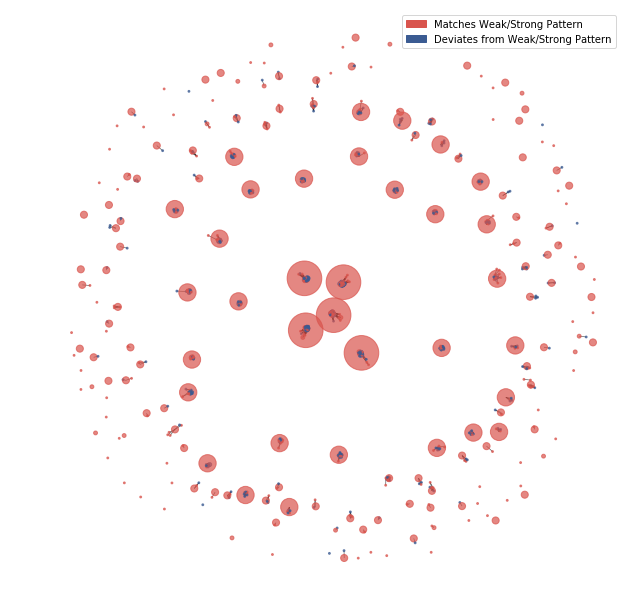

In [6]:
def get_col_list(keys):
    p = re.compile('([AT][GC]){15}')
    def get_nc(bc):
        if p.search(bc):
            return sns.xkcd_rgb['pale red']
        else:
            return sns.xkcd_rgb['denim blue']
    
    cols = map(get_nc, keys)
    return cols

def cc_graph_plot(bc_list, title='graph', sizeplot=True):
    hd_lim = 3 #BCs that differ by Hamming distance less than this value will be merged
    cnts = Counter(bc_list)
    ham_mat = np.matrix([[hamming(k1,k2) for k2 in cnts.keys()] for k1 in cnts.keys()])
    adj_mat = np.matrix(ham_mat < hd_lim, dtype=int)
    G=nx.from_numpy_matrix(adj_mat)
    
    plt.clf()
    plt.figure(figsize=(8,8))
    col_list = get_col_list(cnts.keys())
    if sizeplot:
        def node_size(num):
            if num<10:
                return 3.5
            elif num<100:
                return 15
            elif num<1000:
                return 50
            elif num<10000:
                return 300
            return 1200
        sizes = [node_size(cnts[k]) for k in cnts.keys()]
    else:
        sizes=3.5
    nx.draw(G, with_labels=False, node_color=col_list, node_size=sizes, width=0.6, alpha=0.7)
    
    red_patch = mpatches.Patch(color=sns.xkcd_rgb['pale red'], label='Matches Weak/Strong Pattern')
    blue_patch = mpatches.Patch(color=sns.xkcd_rgb['denim blue'], label='Deviates from Weak/Strong Pattern')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()
    
cc_graph_plot(trm6_menu, 'gef1')

#### Count the barcodes

In [7]:
#plot all the barcodes found in a single graph.
every_bc = pot_bcs + gef1_menu + gef2_menu + gef3_menu + \
        trm4_menu + trm5_menu + trm6_menu + dmso7_menu + dmso8_menu

In [8]:
len(every_bc)

3988927

## Merging BCs by connected component

In [9]:
# WARNING SLOW.
# Builds the {bc:true_bc} dictionary from the combined bc list that is 
# used to merge bcs on a sample-by-sample basis
hd_lim = 3 #BCs that differ by Hamming distance less than this value will be merged
cnts = Counter(every_bc)
ham_mat = np.matrix([[hamming(k1,k2) for k2 in cnts.keys()] for k1 in cnts.keys()])
adj_mat = np.matrix(ham_mat < hd_lim, dtype=int)
G=nx.from_numpy_matrix(adj_mat)

In [10]:
#Extract the connected components
ccs = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
#Keys to look up the BC string from the index in the connected component
keys = cnts.keys()

print "Total CCs: ", len(ccs)

Total CCs:  4777


In [11]:
#regex to check Weak/Strong pattern
p = re.compile('([AT][GC]){15}')
freq_lim = 10 #A representative must be freq_lim* more frequent than all others in the CC.

bc_map = {}
alt_reps = {}
discarded_ccs, discarded_bcs, discarded_bcs_tot = 0,0,0 #the number of discarded ccs.
for cc in ccs:
    bcs = sorted([(cnts[keys[c]], keys[c]) for c in cc], reverse=True)
    #find a representative
    rep = ''
    for n, bc in bcs:
        rx = p.search(bc)
        if rx:
            rep_n, rep = n, bc
            break

    #CCs with no W/S representative are ignored.
    if rep!='':
        
        for bc in map(lambda x : x[1], bcs):
            bc_map[bc] = rep

        alt_reps[rep] = []
        for n, bc in bcs:
            if bc!=rep and freq_lim*n > rep_n:
                rx = p.search(bc) #alternative representatives must be W/S
                if rx:
                    alt_reps[rep].append(bc)
    else:
        discarded_ccs += 1
        discarded_bcs += len(cc)
        discarded_bcs_tot += sum(map(lambda x : x[0], bcs))

print "CCs dropped: ", discarded_ccs
print "Unique BCs dropped: ", discarded_bcs
print "Total BCs dropped: ", discarded_bcs_tot, "(",float(discarded_bcs_tot)/len(every_bc),"%)"

CCs dropped:  60
Unique BCs dropped:  103
Total BCs dropped:  12914 ( 0.00323746210447 %)


In [12]:
#Performs the merge for each sample.
def merge_sample_bcs(sample_bcs):
    sample_cnts = Counter(sample_bcs)
    merged_cnts = {}
    #A dictionary of bc:cnt with all merged BCs combined into a single representative
    for b,bn in sample_cnts.items():
        if b in bc_map: #BCs not in bc_map have no representative
            rep = bc_map[b]
            
            if not rep:
                print "!"
            

            #We split the bc count between each representatives when appropriate (equal HD from both)
            reps, rep_ns = [rep],[bn]
            if len(alt_reps[rep])>0:
                min_hd = min(map(lambda x : hamming(b,x), alt_reps[rep]+[rep]))
                min_reps = filter(lambda x : hamming(b,x)==min_hd, alt_reps[rep]+[rep])

                reps = min_reps
                rep_ns = [bn/len(reps) for _ in reps] #integer division, may lose some BCs

            for r,rn in zip(reps, rep_ns):
                if rep in merged_cnts:
                    merged_cnts[rep]+=rn
                else:
                    merged_cnts[rep]=rn    
    return merged_cnts

In [13]:
raw_bcs = [pot_bcs, dmso7_menu, dmso8_menu, gef1_menu, gef2_menu, gef3_menu, trm4_menu, trm5_menu, trm6_menu]
names = ['POT', 'DMSO7', 'DMSO8', 'GEF1', 'GEF2', 'GEF3', 'TRM4', 'TRM5', 'TRM6']
for bcl, name in zip(raw_bcs, names):
    merged_cnts = merge_sample_bcs(bcl)
    np.save('./data/merged/'+name+'.npy', merged_cnts)

    with open('./data/merged/'+name+'.txt', 'w') as bc_f:
        for key, val in merged_cnts.items():
            for _ in range(val):
                bc_f.write(key+'\n')
    
    

## Loading the Merged BC lists

In [14]:
def load_merged(name):
     return np.load('./data/merged/'+name+'.npy', allow_pickle=True).item()

In [15]:
combined_pot = load_merged('POT')
combined_gef1 = load_merged('GEF1')
combined_gef2 = load_merged('GEF2')
combined_gef3 = load_merged('GEF3')
combined_trm4 = load_merged('TRM4')
combined_trm5 = load_merged('TRM5')
combined_trm6 = load_merged('TRM6')
combined_dmso7 = load_merged('DMSO7')
combined_dmso8 = load_merged('DMSO8')

cbcs = [combined_pot, combined_dmso7, combined_dmso8, combined_gef1, combined_gef2, combined_gef3,
        combined_trm4, combined_trm5, combined_trm6]
names = ['POT', 'DMSO7', 'DMSO8', 'GEF1', 'GEF2', 'GEF3', 'TRM4', 'TRM5', 'TRM6']

[289878, 477630, 409384, 593363, 611425, 371659, 556895, 297299, 368473]
[2295, 1075, 1326, 661, 1000, 956, 218, 196, 184]


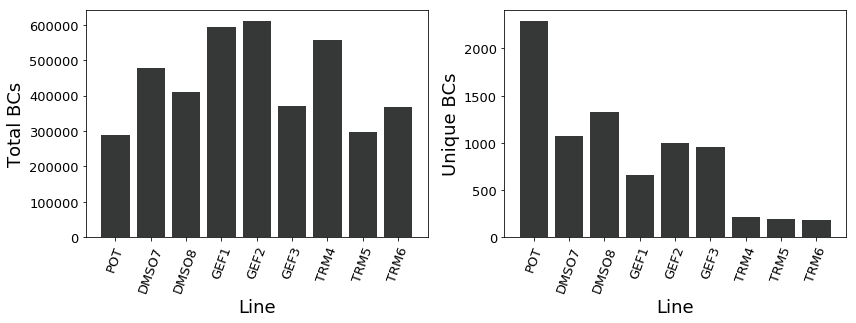

In [16]:
plt.figure(figsize=(12,5))
locs, totals, uniqs, labels = [],[],[],[]
for ix, name in enumerate(names):
    locs.append(0.5*(1+ix))
    totals.append(sum(cbcs[ix].values()))
    uniqs.append(len(cbcs[ix].keys()))
    labels.append(name)

print totals
print uniqs
plt.subplot(121)
plt.yticks(size=13)
plt.xticks(locs, labels, size=13, rotation=70)
plt.xlabel('Line', size=18)
plt.ylabel('Total BCs', size=18)
plt.bar(locs, totals, width=0.4, facecolor=sns.xkcd_rgb['dark grey'])

plt.subplot(122)
plt.yticks(size=13)
plt.xticks(locs, labels, size=13, rotation=70)
plt.xlabel('Line', size=18)
plt.ylabel('Unique BCs', size=18)
plt.bar(locs, uniqs, width=0.4, facecolor=sns.xkcd_rgb['dark grey'])
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## Merging the floating barcodes

In [17]:
#Load the floating BC time points
gef1_f1 = bc_loader('./data/extracted/17-07-28_Gef1_S3.txt')
gef1_f2 = bc_loader('./data/extracted/17-08-04_Gef1_S8.txt')
gef1_f3 = bc_loader('./data/extracted/17-08-11_Gef1_S12.txt')
gef1_f4 = bc_loader('./data/extracted/17-08-18_Gef1_S17.txt')

gef2_f1 = bc_loader('./data/extracted/17-07-28_Gef2_S4.txt')
gef2_f2 = {} #04/08 failed
gef2_f3 = bc_loader('./data/extracted/17-08-11_Gef2_S13.txt')
gef2_f4 = bc_loader('./data/extracted/17-08-18_Gef2_S18.txt')

gef3_f1 = bc_loader('./data/extracted/17-07-28_Gef3_S5.txt')
gef3_f2 = {} #04/08 failed
gef3_f3 = bc_loader('./data/extracted/17-08-11_Gef3_S14.txt')
gef3_f4 = bc_loader('./data/extracted/17-08-18_Gef3_S19.txt')

trm4_f1 = bc_loader('./data/extracted/17-07-28_Tramet4_S6.txt')
trm4_f2 = bc_loader('./data/extracted/17-08-04_Tramet4_S9.txt')
trm4_f3 = bc_loader('./data/extracted/17-08-11_Tramet4_S15.txt')
trm4_f4 = bc_loader('./data/extracted/17-08-18_Tramet4_S20.txt')
trm4_f5 = bc_loader('./data/extracted/17-08-25_Tramet4_S23.txt')
trm4_f6 = bc_loader('./data/extracted/17-09-01_Tramet4_S26.txt')
trm4_f7 = bc_loader('./data/extracted/17-09-08_Tramet4_S29.txt')
trm4_f8 = bc_loader('./data/extracted/17-09-15_Tramet4_S32.txt')
trm4_f9 = bc_loader('./data/extracted/17-09-22_Tramet4_S35.txt')

trm5_f1 = {} #28/07 - failed
trm5_f2 = bc_loader('./data/extracted/17-08-04_Tramet5_S10.txt')
trm5_f3 = bc_loader('./data/extracted/17-08-11_Tramet5_S16.txt')
trm5_f4 = bc_loader('./data/extracted/17-08-18_Tramet5_S21.txt')
trm5_f5 = bc_loader('./data/extracted/17-08-25_Tramet5_S24.txt')
trm5_f6 = bc_loader('./data/extracted/17-09-01_Tramet5_S27.txt')
trm5_f7 = bc_loader('./data/extracted/17-09-08_Tramet5_S30.txt')
trm5_f8 = bc_loader('./data/extracted/17-09-15_Tramet5_S33.txt')
trm5_f9 = bc_loader('./data/extracted/17-09-22_Tramet5_S36.txt')


trm6_f1 = bc_loader('./data/extracted/17-07-28_Tramet6_S7.txt')
trm6_f2 = bc_loader('./data/extracted/17-08-04_Tramet6_S11.txt')
trm6_f3 = {} #11/08 - failed
trm6_f4 = bc_loader('./data/extracted/17-08-18_Tramet6_S22.txt')
trm6_f5 = bc_loader('./data/extracted/17-08-25_Tramet6_S25.txt')
trm6_f6 = bc_loader('./data/extracted/17-09-01_Tramet6_S28.txt')
trm6_f7 = bc_loader('./data/extracted/17-09-08_Tramet6_S31.txt')
trm6_f8 = bc_loader('./data/extracted/17-09-15_Tramet6_S34.txt')
trm6_f9 = bc_loader('./data/extracted/17-09-22_Tramet6_S37.txt')

In [18]:
raw_bcs = [gef1_f1, gef1_f2, gef1_f3, gef1_f4,
           gef2_f1, gef2_f2, gef2_f3, gef2_f4,
           gef3_f1, gef3_f2, gef3_f3, gef3_f4,
           trm4_f1,trm4_f2,trm4_f3,trm4_f4,trm4_f5, trm4_f6,trm4_f7,trm4_f8, trm4_f9, 
           trm5_f1,trm5_f2,trm5_f3,trm5_f4,trm5_f5, trm5_f6,trm5_f7,trm5_f8, trm5_f9,
           trm6_f1,trm6_f2,trm6_f3,trm6_f4,trm6_f5, trm6_f6,trm6_f7,trm6_f8, trm6_f9]

names = ['g1f1', 'g1f2', 'g1f3', 'g1f4',
         'g2f1', 'g2f2', 'g2f3', 'g2f4',
         'g3f1', 'g3f2', 'g3f3', 'g3f4',
         't4f1','t4f2', 't4f3', 't4f4', 't4f5', 't4f6', 't4f7', 't4f8', 't4f9',
         't5f1','t5f2', 't5f3', 't5f4', 't5f5', 't5f6', 't5f7', 't5f8', 't5f9',
         't6f1','t6f2', 't6f3', 't6f4', 't6f5', 't6f6', 't6f7', 't6f8', 't6f9']

for bcl, name in zip(raw_bcs, names):
    merged_cnts = merge_sample_bcs(bcl)
    np.save('./data/merged/'+name+'.npy', merged_cnts)

    with open('./data/merged/'+name+'.txt', 'w') as bc_f:
        for key, val in merged_cnts.items():
            for _ in range(val):
                bc_f.write(key+'\n')